Try training on GHZ state using data in complete set of discrete bases.

In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor

In [3]:
L=2
local_dim=2
bond_dim=2

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

Samples_tr: lists indices of the observed basis states at each measurement.

settings: array of corresponding angles

In [5]:
fname_settings = "datasets/settings_z_product_state_random_basis_L=%d.npy"%L
fname_samples = "datasets/samples_z_product_state_random_basis_L=%d.npy"%L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [6]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [7]:
from qtools import pauli_exp

In [8]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [9]:
from torch.utils.data import TensorDataset, DataLoader

In [10]:
from models import MeasurementDataset, ComplexTensor

In [11]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

In [12]:
batch_size = 64
lr = .01

In [13]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [14]:
losses = []

Number of epochs of training

In [15]:
eps = 5

In [16]:
nstep=1

In [17]:
max_sv = None
cutoff=1e-10

In [18]:
s2_schedule = np.concatenate( [np.linspace(0.1, 0, (eps-1) * len(dl)), np.zeros(len(dl))])

In [19]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        #get torch tensors representing measurement outcomes, and corresponding local unitaries
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        
        s2_penalty = s2_schedule[ep*len(dl) + step]
        #forward sweep across the chain
        for i in range(L-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='left',max_sv_to_keep=max_sv, 
                                       learning_rate=lr, s2_penalty=s2_penalty)   
        for i in range(L-2, -1,-1):
            for __ in range(nstep):
                psi.do_sgd_step(i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='right',max_sv_to_keep=max_sv, 
                                       learning_rate=lr, s2_penalty=s2_penalty)   
        with torch.no_grad():
            losses.append(psi.nll_loss(spinconfig,rotation=rotations))
            
           
        
    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4


In [20]:
import matplotlib.pyplot as plt

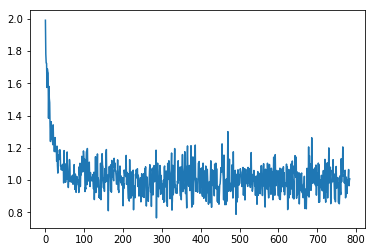

In [21]:
%matplotlib inline
plt.plot(losses)

In [22]:
from tools import generate_binary_space

In [23]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [24]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1]) has probability 0.0001
tensor([1, 0]) has probability 0.0025
tensor([0, 1]) has probability 0.0029
tensor([0, 0]) has probability 0.9944


In [25]:
with torch.no_grad():
    for i in range(len(basis)):
        a = psi.amplitude_normalized(basis[i])
        print("{0} has amplitude {1:.4f} + i{2:.4f}".format(basis[i], a.real.item(), a.imag.item()))

tensor([1, 1]) has amplitude -0.0011 + i-0.0114
tensor([1, 0]) has amplitude 0.0157 + i0.0477
tensor([0, 1]) has amplitude -0.0337 + i-0.0422
tensor([0, 0]) has amplitude 0.8560 + i-0.5116
